# Feed Forward SNN mit Batched Input für effizienteres Training

In [9]:
# dataloading 

import sys
import os
sys.path.append("/home/karl-/liquidstatemachines")
from data.dataloader import *
from data.dummy_event_based_classification_dataset import *
import tonic.transforms as transforms
from torch.utils.data import DataLoader
from tonic import MemoryCachedDataset
from utils.spike_plots import *

transform = transforms.ToFrame(
    sensor_size=tonic.datasets.SHD.sensor_size,  # = (700,),
    n_time_bins=250
    
)
train_dataset=DummySpikeDataset(300,10000)
cached_train_dataset = MemoryCachedDataset(train_dataset, transform=transform)
train_dataloader=DataLoader(cached_train_dataset,batch_size=32)

test_dataset=DummySpikeDataset(300,10000,21)
cached_test_dataset = MemoryCachedDataset(test_dataset, transform=transform)
test_dataloader=DataLoader(cached_test_dataset,batch_size=32)

events, labels = next(iter(train_dataloader))

In [10]:
import torch.nn as nn
from models.sffnn_batched import *

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
ffn = Net(num_inputs=700,num_hidden=1000,num_outputs=2,num_steps=250,beta=0.95).to(device)

In [11]:
events, labels = next(iter(train_dataloader))  # z. B. events: [B, T, 1, 700]
print(f"Original events shape: {events.shape}")

events = events.squeeze(2).to(device).float()  # → [B, T, 700]
print(f"After squeeze shape: {events.shape}")
labels = labels.to(device)
print(f"Labels: {labels[:10]}")
print(f"Unique labels: {torch.unique(labels)}")
spk_rec, mem_rec = ffn(events)  # spk_rec: [B, T, 2]
spike_sums = spk_rec.sum(dim=1)  # über Zeit → [B, 2]
pred_labels = torch.argmax(spike_sums, dim=1)  # [B]
loss_fn = nn.CrossEntropyLoss()
loss = loss_fn(spike_sums, labels)

Original events shape: torch.Size([32, 250, 1, 700])
After squeeze shape: torch.Size([32, 250, 700])
Labels: tensor([0, 1, 0, 0, 1, 1, 0, 0, 0, 0], device='cuda:0')
Unique labels: tensor([0, 1], device='cuda:0')


In [12]:
optimizer = torch.optim.Adam(ffn.parameters(), lr=5e-4)

def train_one_epoch(net, dataloader, optimizer, loss_fn, device):
    net.train()
    total_loss = 0
    correct = 0
    total = 0

    for events, labels in dataloader:
        # events: [B, T, 1, 700] → [B, T, 700]
        events = events.squeeze(2).to(device).float()  # Entferne reshape, nutze squeeze
        
        labels = labels.to(device)

        optimizer.zero_grad()

        # Forward pass
        spk_rec, _ = net(events)              # spk_rec: [B, T, num_outputs]
        spike_sums = spk_rec.sum(dim=1)       # Rate Coding: [B, num_outputs]
        print(f"Spike mean: {spk_rec.mean().item()}")
        print(f"Spike max: {spk_rec.max().item()}")
        print(f"Spike sum per sample: {spk_rec.sum(dim=1)[:5]}")
        print(f"Memory mean: {mem_rec.mean().item()}")
        # Compute loss
        loss = loss_fn(spike_sums, labels)    # labels: [B]
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * labels.size(0)

        # Accuracy
        preds = torch.argmax(spike_sums, dim=1)     # [B]
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / total
    accuracy = correct / total
    print(f"Train Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")
    return avg_loss, accuracy


for epoch in range(1, 20 + 1):
    print(f"\nEpoch {epoch}")
    train_one_epoch(ffn, train_dataloader, optimizer, loss_fn, device)



Epoch 1
Spike mean: 0.0006875000544823706
Spike max: 1.0
Spike sum per sample: tensor([[0., 0.],
        [0., 0.],
        [0., 1.],
        [0., 0.],
        [0., 1.]], device='cuda:0', grad_fn=<SliceBackward0>)
Memory mean: 0.09882313758134842
Spike mean: 0.01587500050663948
Spike max: 1.0
Spike sum per sample: tensor([[8., 0.],
        [8., 0.],
        [8., 0.],
        [8., 0.],
        [9., 0.]], device='cuda:0', grad_fn=<SliceBackward0>)
Memory mean: 0.09882313758134842
Spike mean: 0.0
Spike max: 0.0
Spike sum per sample: tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]], device='cuda:0', grad_fn=<SliceBackward0>)
Memory mean: 0.09882313758134842
Spike mean: 0.0
Spike max: 0.0
Spike sum per sample: tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]], device='cuda:0', grad_fn=<SliceBackward0>)
Memory mean: 0.09882313758134842
Spike mean: 0.0
Spike max: 0.0
Spike sum per sample: tensor([[0., 0.],
      

In [13]:
ffn.eval()
correct = 0
total = 0
with torch.no_grad():
    for events, labels in test_dataloader:
        events = events.squeeze(2).to(device).float()
        labels = labels.to(device)

        spk_rec, _ = ffn(events)
        spike_sums = spk_rec.sum(dim=1)
        preds = torch.argmax(spike_sums, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

print(f"Test Accuracy: {correct / total:.4f}")


Test Accuracy: 0.9767


In [14]:
print(spk_rec.mean().item())  # z. B. ≈ 0.0?
print(spk_rec.sum(dim=1)[:5])  # [B, 2]

0.15466666221618652
tensor([[39., 42.],
        [39., 42.],
        [36., 41.],
        [38., 42.],
        [39., 35.]], device='cuda:0')


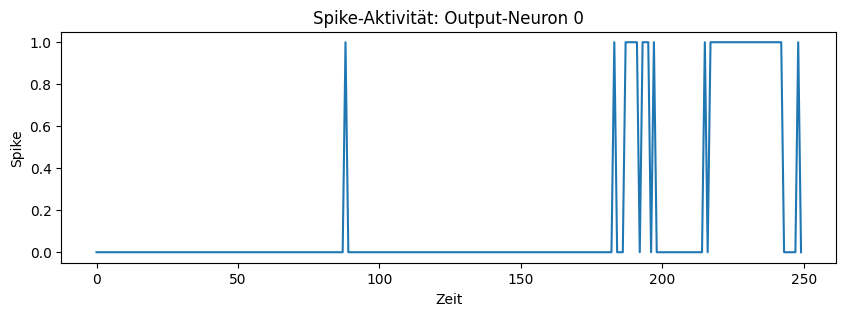

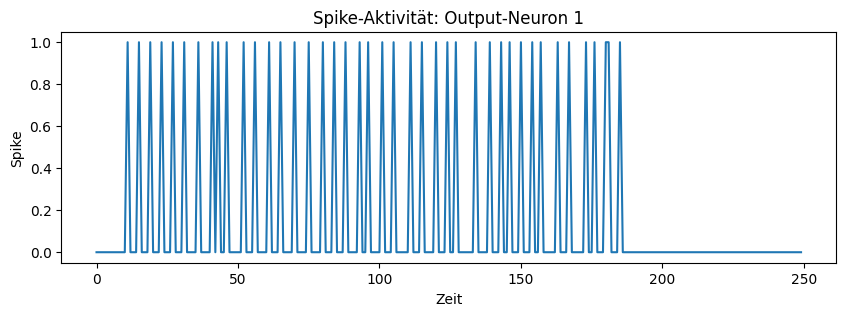

In [15]:
import matplotlib.pyplot as plt

sample_idx = 0  # z. B. erstes Sample im Batch
spk_array = spk_rec[sample_idx].detach().cpu().numpy()  # Shape: [250, 2]


# Einzelne Kurven extrahieren
spk_neuron_0 = spk_array[:, 0]  # alle Zeitschritte, Output-Neuron 0
spk_neuron_1 = spk_array[:, 1]  # alle Zeitschritte, Output-Neuron 1

# Plot 1
plt.figure(figsize=(10, 3))
plt.plot(spk_neuron_0)
plt.title("Spike-Aktivität: Output-Neuron 0")
plt.xlabel("Zeit")
plt.ylabel("Spike")
plt.show()

# Plot 2
plt.figure(figsize=(10, 3))
plt.plot(spk_neuron_1)
plt.title("Spike-Aktivität: Output-Neuron 1")
plt.xlabel("Zeit")
plt.ylabel("Spike")
plt.show()


In [16]:
spike_sums = spk_rec[sample_idx].sum(dim=0)
preds = torch.argmax(spike_sums, dim=0)
print(f"spike sums{spike_sums} and label {preds}")

spike sumstensor([39., 42.], device='cuda:0') and label 1
